# 生存分析

**生存分析（survival analysis）** は、あるイベントの発生確率や、イベント発生までの期間に関わる要因を調べたいときなどに使う。

「イベント」は分野や問題設定によって様々で、例えば医学・疫学においては「死亡」というイベントについて扱う。マーケティングにおいて顧客の「解約」をイベントとしたり、メーカーが機械の「故障」というイベントについて分析・予測するといった応用研究もある。

通常、イベントが発生した場合、それ以降その個体のデータは得られなくなる（脱落する；打ち切りデータ censored data となる）


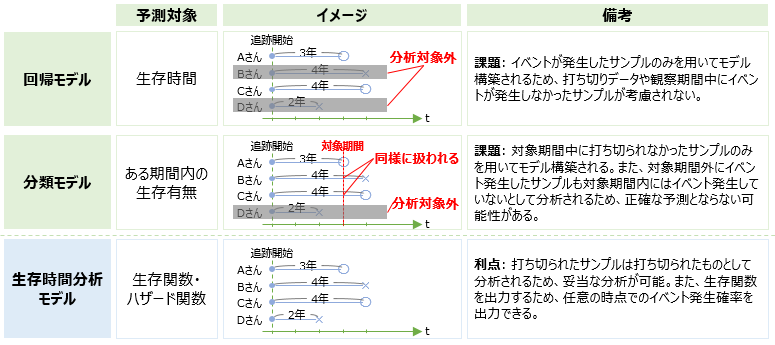

（出所：[生存時間分析入門 | 株式会社ARISE analytics（アライズ アナリティクス）](https://www.ariseanalytics.com/activities/report/20211027/)）

### データの例

In [57]:
import pandas as pd

df = pd.DataFrame([
    (True, 1),
    (True, 3),
    (False, 5),
    (True, 7),
    (True, 9),
    (False, 11),
    (False, 13),
    (True, 15),
], columns=["status", "days"])
df = df.sample(frac=1, random_state=0).reset_index(drop=True)
df["id"] = range(1, df.shape[0]+1)
df = df[["id", "status", "days"]]
df

,id,status,days
0,1,False,13
1,2,False,5
2,3,True,3
3,4,True,15
4,5,True,7
5,6,True,1
6,7,False,11
7,8,True,9


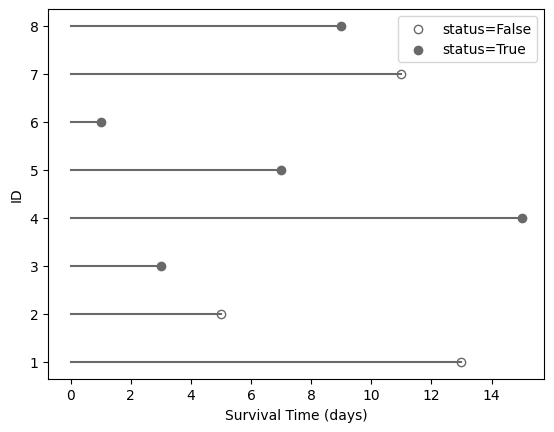

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for status in df["status"].unique():
    idx = df["status"] == status
    color = "dimgray" if status else "white"
    ax.scatter(df.loc[idx, "days"], df.loc[idx, "id"], label=f"status={status}", color=color, edgecolors="dimgray")
    for _, row in df.loc[idx, :].iterrows():
        x1 = 0
        x2 = row["days"]
        y1 = y2 = row["id"]
        ax.plot([x1, x2], [y1, y2], color="dimgray")
ax.legend()
ax.set(xlabel="Survival Time (days)", ylabel="ID")
fig.show()

## ハザード関数

### 生存率関数

ある患者の生存時間を表す確率変数を$T$とする（$T>0$）。

$T$の確率密度関数（PDF）を$f(t)$とする。$f(t)$は「期間tが経過した時点で死亡する確率」を意味する。

$T$の累積分布関数（CDF）は

$$
F(t) = P(T \leq t) = \int^t_0 f(u) du
$$

$F(t)$は「期間tが経過するまでに死亡している確率」である。


$F(t)$をベースに、「期間tが経過するまで死亡していない確率」を意味する **生存率関数（survival rate function）** あるいは **生存関数 （survival function）** と呼ばれる関数 $S(t)$を考えることができる

$$
S(t) = P(T > t) = 1 - F(t)
= \int_t^\infty f(u) du
$$


$$
f(t) = - \frac{d S(t)}{d t}
$$

という関係になる

### 生存率関数の推定

もし正確な生存時間が観測できているなら（研究終了時までに全固体が死亡しているなら）、生存関数は単純に

$$
\hat{S}(t) = \frac{ \text{$t$日を超えて生存している個体数} }{ \text{全個体数} }
$$

で推定できる。

例えば

|      | Status | Survival_in_days |
| ---: | -----: | ---------------: |
|    1 |   True |              8.0 |
|    2 |   True |             10.0 |
|    3 |   True |             20.0 |
|    4 |  False |             25.0 |
|    5 |   True |             59.0 |

というデータの場合、$\hat{S}(t=11)$は全員が11日目を観測しているので計算できるが、$\hat{S}(t=30)$は4番目の個体がまだ30日目を観測していないのでわからない

この場合、カプラン・マイヤー推定量（[Kaplan–Meier estimator - Wikipedia](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator)）などで推定を行うことになる

### 生存曲線（カプラン・マイヤー曲線）

横軸に時間、縦軸に生存率をとった折れ線グラフ


例えば、次のようなデータがあったとする。

In [69]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
df = pd.DataFrame(data_y)
df.head(4)

,Status,Survival_in_days
0,True,72.0
1,True,411.0
2,True,228.0
3,True,126.0


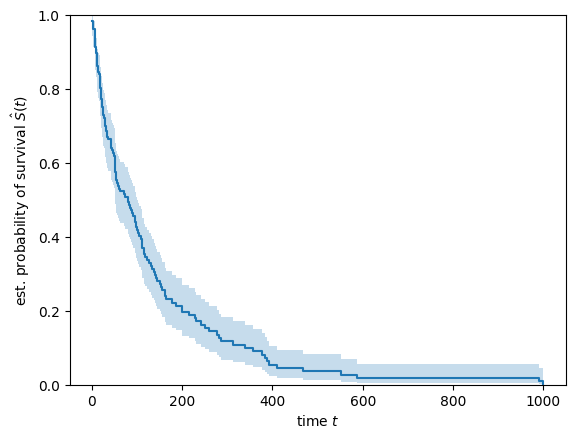

In [66]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    event=data_y["Status"],
    time_exit=data_y["Survival_in_days"],
    conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

時間あたりのイベント発生例数　→　単位時間を短くして、瞬間あたりの死亡率としたのがハザード

### ハザード関数

**ハザード関数** （hazard function）は、「ある時点まで生存していたことを前提にして、その時点に於いて死亡する確率」という条件付き確率

$$
h(t) = \lim_{dt\to 0} \frac{P(T \leq t + dt| T > t)}{dt}
$$

例えば10歳での生存率と90歳の生存率を比べると、90歳の生存率はかなり低くなると考えられる。

そこを「89歳まで生存していた人が90歳に死亡する確率」と条件付きにすることで、真に測りたい率を得る。

整理すると

$$
\begin{align}
h(t)
&= \lim_{dt\to 0} \frac{P(T \leq t + dt| T > t)}{dt}\\
&= \lim_{dt\to 0} \frac{P(t < T \leq t + dt)}{P(T > t) dt} \quad (\because \frac{P(T > t)}{P(T > t)}を乗じて分子を同時確率にした)\\
&= \lim_{dt\to 0} \frac{P(t + dt) - P(t)}{dt} \times \frac{1}{P(T > t)}\\
&= \frac{d F(t)}{d t} \times \frac{1}{P(T > t)}\\
&= \frac{f(t)}{S(t)}\\
\end{align}
$$

なので

$$
h(t) = \frac{f(t)}{S(t)}
= \frac{\text{t期に死亡する確率} }{\text{t期まで生存している確率} }
$$

という関係になる

### ハザード比

ハザード比とは、イベント（死亡）の起こりやすさを試験期間全体の平均的な群間差として推定したもの。

通常は分子に新治療のハザード、分母に既存治療のハザードとして相対的な効果の大きさを推算する。

## MLの活用

[[1708.04649] Machine Learning for Survival Analysis: A Survey](https://arxiv.org/abs/1708.04649)

## ライブラリ

- [scikit-survival — scikit-survival 0.23.0](https://scikit-survival.readthedocs.io/en/stable/index.html)

[Understanding Predictions in Survival Analysis — scikit-survival 0.23.0](https://scikit-survival.readthedocs.io/en/stable/user_guide/understanding_predictions.html)

## モデルの評価

### c-index

ROC-AUCに時間軸情報を足したもの？

解説：

- [一番わかりやすいROC曲線とAUCとC統計量｜岡田遥平 | Yohei Okada（救急医）](https://note.com/yohei_okada/n/nd384bd62c6d5)

使用例：
- [A comparison of machine learning methods for survival analysis of high-dimensional clinical data for dementia prediction](https://www.nature.com/articles/s41598-020-77220-w) ではc-indexの平均でモデルを比較している


## 参考

- [武冨奈菜美, & 山本和嬉. (2023). 生存時間解析・信頼性解析のための統計モデル. 日本統計学会誌, 52(2), 69-112.](https://www.jstage.jst.go.jp/article/jjssj/52/2/52_69/_pdf)
- [生存時間分析入門 | 株式会社ARISE analytics（アライズ アナリティクス）](https://www.ariseanalytics.com/activities/report/20211027/)
- [ハザード比｜医療統計｜ビーリンサイト.jp](https://www.blincyto.jp/documents/medical_statistics08)